# Google Speech to Text API

### Packages and Config

In [8]:
import sys
import io
import random
import pandas as pd
import os
import pathlib
import yaml
import librosa 
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import scipy.stats as stats
from google.cloud import speech
from scipy.io import wavfile
import IPython.display as ipd

from scipy.io import wavfile
import IPython.display as ipd

# Set WD
try:
    os.chdir('../../df-shibboleth/')
except:
    print(f'Working directory set to: {os.getcwd()}')

# Import configs
with open('XX Data/config.yaml', 'r') as file:
    inputs = yaml.safe_load(file)

Working directory set to: /Users/sarah/Documents/GitHub/berkeley/df-shibboleth


# Authenticate & Test Google

In [2]:
# from google.cloud import speech

# # Instantiates a client
# client = speech.SpeechClient()

# # The name of the audio file to transcribe
# gcs_uri = "gs://cloud-samples-data/speech/brooklyn_bridge.raw"

# audio = speech.RecognitionAudio(uri=gcs_uri)

# config = speech.RecognitionConfig(
#     encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
#     sample_rate_hertz=16000,
#     language_code="en-US",
#     enable_word_time_offsets=True
# )

# # Detects speech in the audio file
# response = client.recognize(config=config, audio=audio)

# for result in response.results:
#     print("Transcript: {}".format(result.alternatives[0].transcript))


# Develop Timestamp Extraction Pipeline

In [10]:
client = speech.SpeechClient()

In [5]:
def print_result(result: speech.SpeechRecognitionResult):
    best_alternative = result.alternatives[0]
    print("-" * 80)
    print(f"language_code: {result.language_code}")
    print(f"transcript:    {best_alternative.transcript}")
    print(f"confidence:    {best_alternative.confidence:.0%}")
    print("-" * 80)
    for word in best_alternative.words:
        start_s = word.start_time.total_seconds()
        end_s = word.end_time.total_seconds()
        print(f"{start_s:>7.3f} | {end_s:>7.3f} | {word.word}")
        
def print_response(response: speech.RecognizeResponse):
    for result in response.results:
        print_result(result)
        
#print_response(response)

In [63]:
def extract_input_files(data_input_path):

    all_wav_files = pathlib.Path(data_input_path)
    all_wav_files = list(all_wav_files.rglob("*.wav")) + list(all_wav_files.rglob("*.WAV"))
    all_wav_files = [str(file) for file in all_wav_files]

    #real_resampled_wav_files = [file for file in all_wav_files if 'TIMIT converted' in file]
    #fake_resampled_wav_files = [file for file in all_wav_files if not 'TIMIT converted' in file]

    flags = [1 if 'TIMIT converted' in str(item) else 0 for item in all_wav_files]
    
    return all_wav_files, flags #real_resampled_wav_files, fake_resampled_wav_files, flags

data_input_path = '/Volumes/2022_OTHER/TIMIT-fake/elevenlabs_adam'
adam_files, _ = extract_input_files(data_input_path)
    
# Obtain sample rate
fake_sr = librosa.load(adam_files[0])[1]

In [8]:
config = speech.RecognitionConfig(
    encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
    sample_rate_hertz=44100,
    language_code="en-US",
    enable_word_time_offsets=True
)

In [11]:
test_audio_path = adam_files[0]

with io.open(test_audio_path, "rb") as f:
    content = f.read()
    audio = {"content": content}
    
response = client.recognize(config=config, audio=audio)

print_response(response)

--------------------------------------------------------------------------------
language_code: en-us
transcript:    assume for example a situation where a farm has a Packing Shed and Fields
confidence:    90%
--------------------------------------------------------------------------------
  0.000 |   0.400 | assume
  0.400 |   0.500 | for
  0.500 |   1.000 | example
  1.000 |   1.100 | a
  1.100 |   1.700 | situation
  1.700 |   1.800 | where
  1.800 |   1.900 | a
  1.900 |   2.300 | farm
  2.300 |   2.400 | has
  2.400 |   2.500 | a
  2.500 |   2.900 | Packing
  2.900 |   3.300 | Shed
  3.300 |   3.400 | and
  3.400 |   4.000 | Fields


In [12]:
filename = adam_files[0].split('.')[0].split('/')[-1] + '.txt'
filename

'elevenlabs_adam_FAEM0_SI1392.txt'

In [13]:
import re
filename = adam_files[0].split('.')[0].split('/')[-1] + '.txt'
output_dir = '/Volumes/2022_OTHER/TIMIT-fake/transcriptions/'
timestamps_words = []
timestamps_starts = []
timestamps_ends = []

for result in response.results:
    alternative = result.alternatives[0]
    
    for word in alternative.words:
        timestamps_words.append(word.word)
        timestamps_starts.append(word.start_time)
        timestamps_ends.append(word.end_time)
    
    timestamps_words = [re.sub(r'[^\w\s]', '', word).lower() for word in timestamps_words]
    timestamps_starts = [int((item / pd.to_timedelta(1, unit='s'))*sr) for item in timestamps_starts]
    timestamps_ends = [int((item / pd.to_timedelta(1, unit='s'))*sr) for item in timestamps_ends]
    
    df = pd.DataFrame({'start':timestamps_starts, 'end':timestamps_ends, 'word':timestamps_words})
    
    #with open(filename, 'wb') as out:
    for idx, row in df.iterrows():
        print([' '.join(str(num) for num in row)])
    #    out.write(' '.join(str(num) for num in frame))
    #    out.write('\r\n')

['0 8820 assume']
['8820 11025 for']
['11025 22050 example']
['22050 24255 a']
['24255 37485 situation']
['37485 39690 where']
['39690 41895 a']
['41895 50714 farm']
['50714 52920 has']
['52920 55125 a']
['55125 63945 packing']
['63945 72765 shed']
['72765 74970 and']
['74970 88200 fields']


# Test Pipeline

In [70]:
import os
import wave

with wave.open(adam_files[0], "rb") as wave_file:
    frame_rate = wave_file.getframerate()
print(frame_rate)

44100


In [125]:
data_input_path = '/Volumes/2022_OTHER/TIMIT-fake/'
folders_to_transcribe = ['elevenlabs_adam'] #, 'elevenlabs_LJSpeech', 'elevenlabs_bella',  'elevenlabs_biden']
output_folder = data_input_path + 'transcriptions/'

for folder in folders_to_transcribe:
    
    
    with wave.open(adam_files[0], "rb") as wave_file:
        sr = wave_file.getframerate()
    
    folder_files, _ = extract_input_files(os.path.join(data_input_path, folder))
    
    for file in folder_files[0:1]:
        
        # Obtain transcription
        with io.open(file, "rb") as f:
            content = f.read()
            audio = {"content": content}
            
        config = speech.RecognitionConfig(
            encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
            sample_rate_hertz=sr,
            language_code="en-US",
            enable_word_time_offsets=True
        )

        response = client.recognize(config=config, audio=audio)

        # Format transcription
        timestamps_words = []
        timestamps_starts = []
        timestamps_ends = []
        
        for result in response.results:
            alternative = result.alternatives[0]

            for word in alternative.words:
                timestamps_words.append(word.word)
                timestamps_starts.append(word.start_time)
                timestamps_ends.append(word.end_time)
                
        timestamps_words = [re.sub(r'[^\w\s]', '', word).lower() for word in timestamps_words]
        #timestamps_starts = #[(pd.to_timedelta(item, unit='s').seconds)*sr for item in timestamps_starts]
        #timestamps_ends = #[(pd.to_timedelta(item, unit='s').seconds)*sr for item in timestamps_ends]

        df = pd.DataFrame({'start':timestamps_starts, 'end':timestamps_ends, 'word':timestamps_words})
        
        df['start'] = (df['start']*44100 / np.timedelta64(1, 's')).astype('int')
        df['end'] = (df['end']*44100 / np.timedelta64(1, 's')).astype('int')
        
        file_name = file.split('.')[0].split('/')[-1] + '.txt'
        output_file = os.path.join(output_folder, file_name)
        #df.to_csv(output_file, header=None, index=None, sep=' ')
#def run_transcription():
    
#run_transcription()

In [142]:
print(output_file) # As an example for below

/Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_adam_FAEM0_SI1392.txt


In [141]:
test_file = '/Volumes/2022_OTHER/TIMIT-fake/elevenlabs_adam/elevenlabs_adam_FAEM0_SI1392.wav'
real_test_file = '/Volumes/2022_OTHER/TIMIT-fake/TIMIT converted/wav_files/FAEM0_SI1392.wav'

transcription = output_file
real_transcription = '/Volumes/2022_OTHER/TIMIT-fake/TIMIT converted/word_files/FAEM0_SI1392.txt'

df = pd.read_csv(transcription, delimiter=' ', header=None)
df.columns = ['start', 'end', 'word']

print('******** FAKE ********')
for id_, row in df.iterrows():
    fs, audio = wavfile.read(test_file)
    audio = audio[row['start']:row['end']]
    print(row['word'])
    ipd.display(ipd.Audio(audio, rate=fs))
    
    
df = pd.read_csv(real_transcription, delimiter=' ', header=None)
df.columns = ['start', 'end', 'word']

print('******** REAL ********')
for id_, row in df.iterrows():
    fs, audio = wavfile.read(real_test_file)
    audio = audio[row['start']:row['end']]
    print(row['word'])
    ipd.display(ipd.Audio(audio, rate=fs))

******** FAKE ********
assume


for


example


a


situation


where


a


farm


has


a


packing


shed


and


fields


******** REAL ********
assume


for


example


a


situation


where


a


farm


has


a


packing


shed


and


fields


# Run all (ADAM as first test)

In [143]:
# data_input_path = '/Volumes/2022_OTHER/TIMIT-fake/'
# folders_to_transcribe = ['elevenlabs_adam'] #, 'elevenlabs_LJSpeech', 'elevenlabs_bella',  'elevenlabs_biden']
# output_folder = data_input_path + 'transcriptions/'

# for folder in folders_to_transcribe:
    
    
#     with wave.open(adam_files[0], "rb") as wave_file:
#         sr = wave_file.getframerate()
    
#     folder_files, _ = extract_input_files(os.path.join(data_input_path, folder))
    
#     for file in folder_files:
        
#         # Obtain transcription
#         with io.open(file, "rb") as f:
#             content = f.read()
#             audio = {"content": content}
            
#         config = speech.RecognitionConfig(
#             encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
#             sample_rate_hertz=sr,
#             language_code="en-US",
#             enable_word_time_offsets=True
#         )

#         response = client.recognize(config=config, audio=audio)

#         # Format transcription
#         timestamps_words = []
#         timestamps_starts = []
#         timestamps_ends = []
        
#         for result in response.results:
#             alternative = result.alternatives[0]

#             for word in alternative.words:
#                 timestamps_words.append(word.word)
#                 timestamps_starts.append(word.start_time)
#                 timestamps_ends.append(word.end_time)
                
#         timestamps_words = [re.sub(r'[^\w\s]', '', word).lower() for word in timestamps_words]
#         #timestamps_starts = #[(pd.to_timedelta(item, unit='s').seconds)*sr for item in timestamps_starts]
#         #timestamps_ends = #[(pd.to_timedelta(item, unit='s').seconds)*sr for item in timestamps_ends]

#         df = pd.DataFrame({'start':timestamps_starts, 'end':timestamps_ends, 'word':timestamps_words})
        
#         df['start'] = (df['start']*44100 / np.timedelta64(1, 's')).astype('int')
#         df['end'] = (df['end']*44100 / np.timedelta64(1, 's')).astype('int')
        
#         file_name = file.split('.')[0].split('/')[-1] + '.txt'
#         output_file = os.path.join(output_folder, file_name)
#         df.to_csv(output_file, header=None, index=None, sep=' ')
# #def run_transcription():
    
# #run_transcription()

# Test sample of Adam files

In [144]:
output_file

'/Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_adam_MZMB0_SI536.txt'

In [148]:
new_file = 'MTJM0_SI1226' # 'MTRR0_SI918' failed on 'variety'/character

test_file = f'/Volumes/2022_OTHER/TIMIT-fake/elevenlabs_adam/elevenlabs_adam_{new_file}.wav'
real_test_file = f'/Volumes/2022_OTHER/TIMIT-fake/TIMIT converted/wav_files/{new_file}.wav'

transcription = f'/Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_adam_{new_file}.txt'
real_transcription = f'/Volumes/2022_OTHER/TIMIT-fake/TIMIT converted/word_files/{new_file}.txt'

# **** #
df = pd.read_csv(transcription, delimiter=' ', header=None)
df.columns = ['start', 'end', 'word']

print('******** FAKE ********')
for id_, row in df.iterrows():
    fs, audio = wavfile.read(test_file)
    audio = audio[row['start']:row['end']]
    print(row['word'])
    try:
        ipd.display(ipd.Audio(audio, rate=fs))
    except:
        continue
    
    
df = pd.read_csv(real_transcription, delimiter=' ', header=None)
df.columns = ['start', 'end', 'word']

print('******** REAL ********')
for id_, row in df.iterrows():
    fs, audio = wavfile.read(real_test_file)
    audio = audio[row['start']:row['end']]
    print(row['word'])
    try:
        ipd.display(ipd.Audio(audio, rate=fs))
    except:
        continue

******** FAKE ********
the


wheel


of


social


life


spun


around


the


royal


or


aristocratic


center


******** REAL ********
the


wheel


of


social


life


spun


around


the


royal


or


aristocratic


centre


# Run for the others

In [150]:
file

'/Volumes/2022_OTHER/TIMIT-fake/elevenlabs_LJSpeech/elevenlabs_LJSpeech_FJXP0_SI492.wav'

# NEED TO RUN AND FINISH THIS!

In [153]:
data_input_path = '/Volumes/2022_OTHER/TIMIT-fake/'
folders_to_transcribe = ['elevenlabs_LJSpeech']#, 'elevenlabs_bella',  'elevenlabs_biden']
output_folder = data_input_path + 'transcriptions/'

for folder in folders_to_transcribe:
    
    with wave.open(adam_files[0], "rb") as wave_file:
        sr = wave_file.getframerate()
    
    folder_files, _ = extract_input_files(os.path.join(data_input_path, folder))
    
    for file in folder_files:
        
        file_name = file.split('.')[0].split('/')[-1] + '.txt'
        output_file = os.path.join(output_folder, file_name)
        
        if not os.path.exists(output_file):
        
            # Obtain transcription
            with io.open(file, "rb") as f:
                content = f.read()
                audio = {"content": content}

            config = speech.RecognitionConfig(
                encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
                sample_rate_hertz=sr,
                language_code="en-US",
                enable_word_time_offsets=True
            )

            response = client.recognize(config=config, audio=audio)

            # Format transcription
            timestamps_words = []
            timestamps_starts = []
            timestamps_ends = []

            for result in response.results:
                alternative = result.alternatives[0]

                for word in alternative.words:
                    timestamps_words.append(word.word)
                    timestamps_starts.append(word.start_time)
                    timestamps_ends.append(word.end_time)

            try:
                timestamps_words = [re.sub(r'[^\w\s]', '', word).lower() for word in timestamps_words]
                #timestamps_starts = #[(pd.to_timedelta(item, unit='s').seconds)*sr for item in timestamps_starts]
                #timestamps_ends = #[(pd.to_timedelta(item, unit='s').seconds)*sr for item in timestamps_ends]

                df = pd.DataFrame({'start':timestamps_starts, 'end':timestamps_ends, 'word':timestamps_words})

                df['start'] = (df['start']*44100 / np.timedelta64(1, 's')).astype('int')
                df['end'] = (df['end']*44100 / np.timedelta64(1, 's')).astype('int')

                df.to_csv(output_file, header=None, index=None, sep=' ')

            except:
                file_name = file.split('.')[0].split('/')[-1] + '.txt'
                output_file = os.path.join(output_folder, file_name)
                print(f'Transcription for {output_file} failed. ')
        else:
                print(f'File {output_file} already exists; skipping')
#def run_transcription():
    
#run_transcription()

File /Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_LJSpeech_FAEM0_SI1392.txt already exists; skipping
File /Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_LJSpeech_FAEM0_SI2022.txt already exists; skipping
File /Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_LJSpeech_FAEM0_SI762.txt already exists; skipping
File /Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_LJSpeech_FAEM0_SX222.txt already exists; skipping
File /Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_LJSpeech_FAJW0_SI1263.txt already exists; skipping
File /Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_LJSpeech_FAJW0_SI1893.txt already exists; skipping
File /Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_LJSpeech_FAJW0_SI633.txt already exists; skipping
File /Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_LJSpeech_FAJW0_SX183.txt already exists; skipping
File /Volumes/2022_OTHER/TIMIT-fake/transcriptions/elevenlabs_LJSpeech_FAJW0_SX3.txt already exists;

KeyboardInterrupt: 

# ****

# Examine outputs starting with Adam

In [64]:
def extract_transcripts(files, transcripts_location):
    transcripts = []
    for item in files:
        file_name = '/'+item.split('/')[-1].split('.')[0] + '.txt'
        
        transcript_file = transcripts_location+file_name
        
        transcripts.append(transcript_file)
    
    return transcripts

In [65]:
# Obtain files and check
data_input_path = '/Volumes/2022_OTHER/TIMIT-fake/'

real_files, real_flags = extract_input_files(data_input_path+'TIMIT converted/wav_files')
real_transcripts = extract_transcripts(real_files, data_input_path+'TIMIT converted/word_files')

fake_files, fake_flags = extract_input_files(data_input_path+'elevenlabs_adam')
fake_transcripts = extract_transcripts(fake_files, data_input_path+'transcriptions')

print(len(real_files), len(real_transcripts), len(fake_files), len(fake_transcripts))

4620 4620 1716 1716


In [69]:
# Load and truncate
def extract_words(files, transcripts, sample_rate=44100):
    all_words = []
    all_audios = []
    
    for i in range(len(files)):
        words = []
        word_audios = []
        
        file = files[i]
        transcript = transcripts[i]
        audio = librosa.load(file, sr=sample_rate)[0]
        
        # OPTIONAL: normalize audios
        audio = audio/np.max(np.abs(audio))
        
        word_times = pd.read_csv(transcript, header=None, delimiter=' ')
        word_times.columns = ['start', 'end', 'word']
        
        for id_, row in word_times.iterrows():
            start = row['start']
            end = row['end']
            word = row['word']
            
            trunc_audio = audio[start:end]
            
            words.append(word)
            word_audios.append(trunc_audio)
        
        all_words.append(words)
        all_audios.append(word_audios)
        
    return all_words, all_audios
        
real_words, real_word_audios = extract_words(real_files, real_transcripts, sample_rate=16000)
fake_words, fake_word_audios = extract_words(fake_files, fake_transcripts, sample_rate=44100)

print(len(real_files), len(real_words), len(real_word_audios))
print(len(fake_files), len(fake_words), len(fake_word_audios))

4620 4620 4620
1716 1716 1716


In [70]:
for word in real_word_audios[0:3]:
    ipd.display(ipd.Audio(word[0], rate=16000))
    
for word in fake_word_audios[0:3]:
    ipd.display(ipd.Audio(word[0], rate=44100))

# Basic separation examination: single feature OR PCA? 

USNG CUTOFF FREQUENCY: 20
Average derivative of amplitude: 2.181436695322056e-07
Mean amplitude: 0.03727372121052349
DURATION: 0.40025s


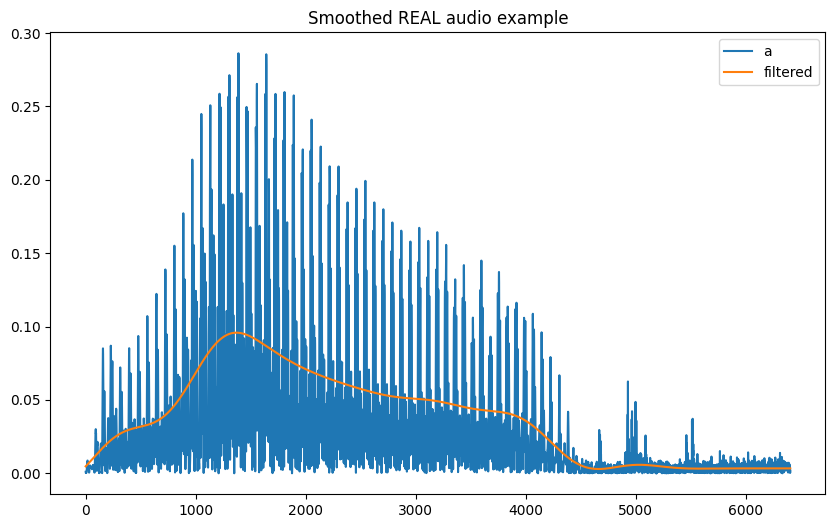

USNG CUTOFF FREQUENCY: 20
Average derivative of amplitude: 5.015063801697258e-05
Mean amplitude: 0.07832553900770114
DURATION: 0.095s


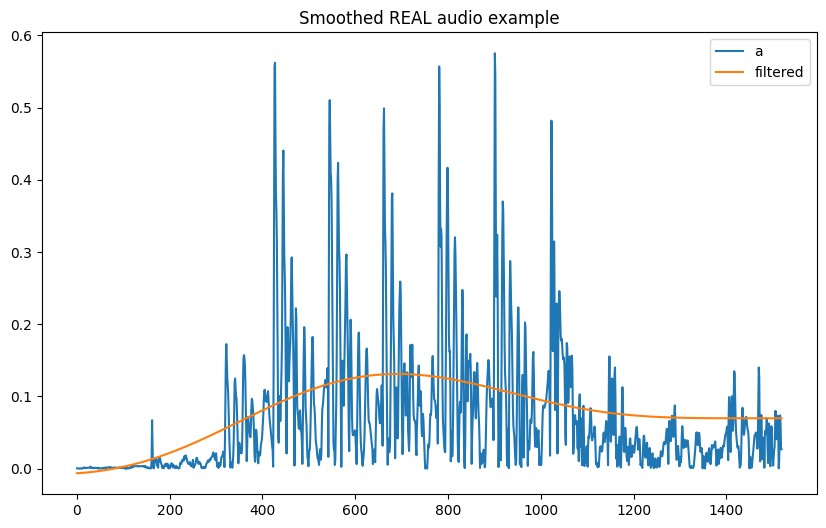

USNG CUTOFF FREQUENCY: 20
Average derivative of amplitude: 3.60194415891969e-06
Mean amplitude: 0.22190922479290343
DURATION: 0.1s


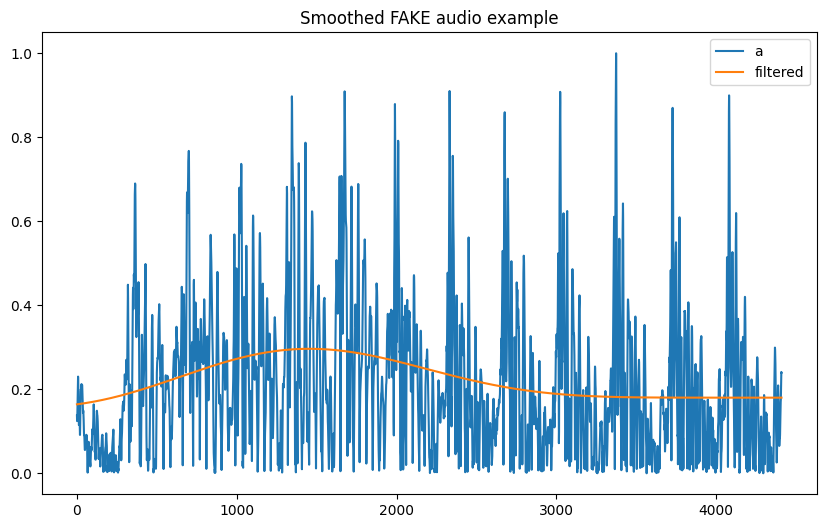

USNG CUTOFF FREQUENCY: 20
Average derivative of amplitude: 1.193862929440532e-05
Mean amplitude: 0.06320207826127668
DURATION: 0.1s


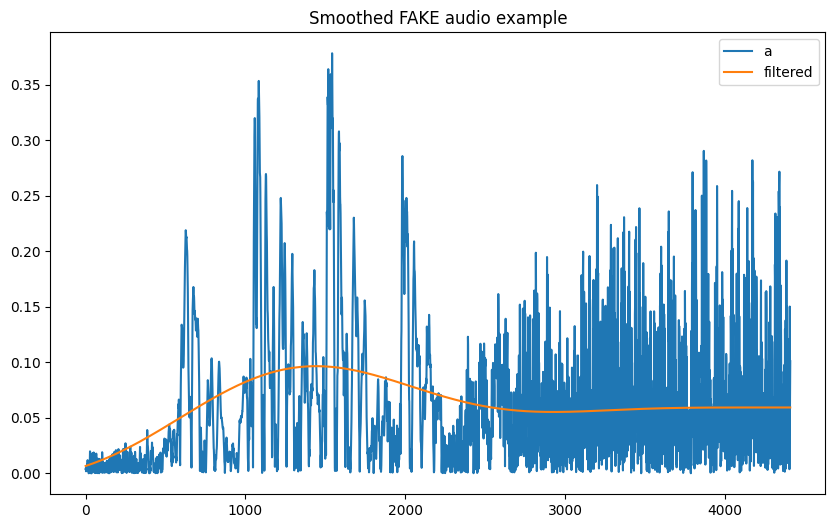

[(3.60194415891969e-06, 0.22190922479290343, 0.1),
 (1.193862929440532e-05, 0.06320207826127668, 0.1)]

In [128]:
from scipy import signal
def filter_signal(audio, sample_rate, cutoff_frequency):
    t = np.arange(len(audio)) / sample_rate 
    w = cutoff_frequency / (sample_rate / 2) 
    b, a = signal.butter(5, w, 'low')
    smoothed_signal = signal.filtfilt(b, a, audio)
    
    return smoothed_signal
    

def get_amplitude(audio, sample_rate=44100, cutoff_frequency=20, zero_indices=False, label='REAL', plot=True, printout=True):
    #thresh = np.mean(abs(audio))*percent - previous idea - use mean to accoiunt for fake sgenerally being louder?
    
    abs_audio = abs(audio)
    try:
        smoothed_signal = filter_signal(abs_audio, sample_rate, cutoff_frequency)

        deriv_amplitude = np.abs(np.mean(np.diff(smoothed_signal)))
        mean_amplitude = np.mean(smoothed_signal)
    except:

        deriv_amplitude = 'NaN'
        mean_amplitude = 'NaN'
    
    duration = len(audio)/sample_rate
    
    
    if printout:
        print(f'USNG CUTOFF FREQUENCY: {cutoff_frequency}')
        print(f'Average derivative of amplitude: {deriv_amplitude}')
        print(f'Mean amplitude: {mean_amplitude}')
        print(f'DURATION: {duration}s')

    
    if plot:
        plt.figure(figsize=(10,6))
        plt.title(f"Smoothed {label} audio example")
        plt.plot(range(len(abs_audio)), abs_audio, label='a')

        plt.plot(range(len(smoothed_signal)), smoothed_signal, label='filtered')
        plt.legend()

        plt.show()
        
        ipd.display(ipd.Audio(audio, rate=sample_rate))
        
    return deriv_amplitude, mean_amplitude, duration

# Test
random.seed(0.4)
[get_amplitude(item, sample_rate=16000) for item in sample(flattened_real_words_audios, 2)]
[get_amplitude(item, sample_rate=44100, label='FAKE') for item in sample(flattened_fake_words_audios, 2)]

### Flatten lists

In [82]:
from random import sample

flattened_real_words_audios = [item for sublist in real_word_audios for item in sublist]
flattened_fake_words_audios = [item for sublist in fake_word_audios for item in sublist]
real_results = []
[real_results.append(get_amplitude(item, sample_rate=16000, plot=False, printout=False)) for item in sample(flattened_real_words_audios, len(flattened_fake_words_audios))]
fake_results = []
[fake_results.append(get_amplitude(item, label='FAKE', plot=False, printout=False)) for item in flattened_fake_words_audios]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### Extract features

In [114]:
# deriv, mean, duration
real_derivs = [float(real_results[i][1]) for i in range(len(real_results))]
fake_derivs = [float(fake_results[i][1]) for i in range(len(fake_results))]

In [115]:
fake_derivs[-1]

0.14006085292571105

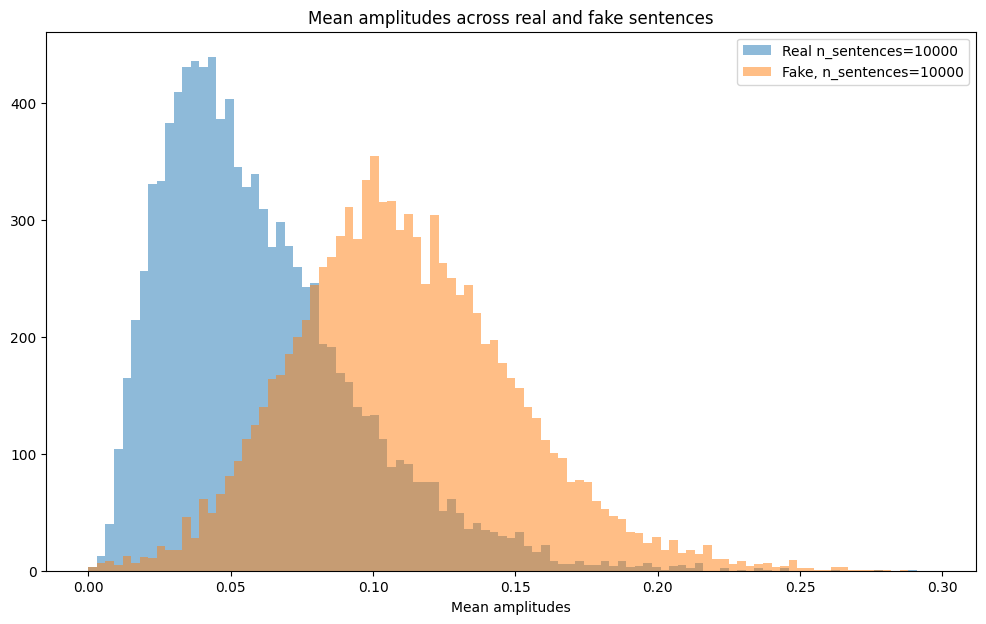

In [120]:
plt.figure(figsize=(12,7))
j = 10000
plt.hist(sample(real_derivs, j), alpha=0.5, label=f'Real n_sentences={len(sample(real_derivs, j))}', bins = np.arange(0, 0.3, 0.3/100))
plt.hist(sample(fake_derivs, j), alpha=0.5, label=f'Fake, n_sentences={len(sample(fake_derivs, j))}', bins = np.arange(0, 0.3, 0.3/100))
plt.legend(loc='upper right')
plt.xlabel('Mean amplitudes')
#plt.ylabel(f'Count (n_files = {len(r1s_deriv)+len(f1s_deriv)}, n_phrases={len(test_folders)})')
plt.title('Mean amplitudes across real and fake sentences')
plt.show()

In [ ]:
#def balance_data():
    

NameError: name 'real_files' is not defined

# Trying Opensmile

4620


## Write all words out to files

In [100]:
import string


'em'

In [138]:
def save_word_audios(ngram, word_audios, words, output_location, sr):
    for i in range(len(word_audios)):
        sentence_audio  = word_audios[i]
        sentence_transcript = words[i]

        for j in range(len(sentence_audio)-ngram):
            word_audio = np.concatenate(sentence_audio[j:j+ngram])
            word_transcript = '_'.join(str(sentence_transcript[j:j+ngram]).replace("'", ""))
            original_file_name = real_files[i].split('/')[-1]
            file_out = os.path.join(output_location, word_transcript+'_'+original_file_name)
            #print(file_out)
            sf.write(f'{file_out}', word_audio, sr)
            
save_word_audios(2, real_word_audios, real_words, '/Volumes/2022_OTHER/TIMIT-fake/word_files/real_bigram', sr=16000)
save_word_audios(2, fake_word_audios, fake_words, '/Volumes/2022_OTHER/TIMIT-fake/word_files/fake_bigram', sr=44100)

In [139]:
beepy.beep()

## Run analysis 

In [142]:
real_word_files = [str(item) for item in list(pathlib.Path('/Volumes/2022_OTHER/TIMIT-fake/word_files/real_bigram').rglob("*.WAV"))]
fake_word_files = [str(item) for item in list(pathlib.Path('/Volumes/2022_OTHER/TIMIT-fake/word_files/fake_bigram').rglob("*.WAV"))]

In [143]:
import opensmile

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

def extract_features(files, label, csv_=True):
    y = smile.process_file(files[0])
    y.reset_index(inplace=True)
    y.index = y['file']

    output = pd.DataFrame(columns=y.columns)
    
    for file in files:
        y = smile.process_file(file)
        y.reset_index(inplace=True)
        y.index = y['file']
        
        output = pd.concat([output, y])
    
    #output.drop(['file'], axis=1, inplace=True)
    
    if csv_:
        output.to_csv(f'XX Data/opensmile_features/os_{label}.csv')
        
    return output

real_os_features = extract_features(real_word_files, 'real')
fake_os_features = extract_features(fake_word_files, 'fake')

In [145]:
beepy.beep()

# PCA 

In [5]:
# Load fe3atures
import pandas as pd 

real_os_features = pd.read_csv(f'XX Data/opensmile_features/os_real.csv')
fake_os_features = pd.read_csv(f'XX Data/opensmile_features/os_fake.csv')

In [6]:
real_os_features['label'] = 0
fake_os_features['label'] = 1
combined = pd.concat([real_os_features, fake_os_features])

failed = 0
counter = 0

for item in combined.columns:    
    try:
        combined[item] = combined[item].astype(float)
    except:
        combined.drop([item], axis=1, inplace=True)
        failed = failed + 1
    
    counter = counter + 1
    
    if counter % 10 == 0:
        print(f'{counter*100/len(combined.colums)}% complete')
    
print(combined.dtypes)
print(failed)        

KeyboardInterrupt: 

In [7]:
import beepy
beepy.beep()

In [8]:
from sklearn.decomposition import PCA
import numpy as np

# create a matrix of data
X = combined

# create a PCA object with 2 components
pca = PCA(n_components=20)

# fit and transform the data
pca.fit(X)
X_pca = pca.transform(X)

# print the variance explained by each component
print(pca.explained_variance_ratio_)

[9.99798358e-01 2.01641792e-04 2.70012278e-10 1.43228149e-10
 4.10143557e-11 2.39952462e-11 2.21387733e-11 9.85486852e-12
 5.48249792e-12 2.66781370e-12 1.21317839e-12 7.87794002e-13
 4.31100589e-13 3.32526402e-13 2.33086629e-13 1.02654687e-13
 6.13000355e-14 4.09168193e-14 2.46810400e-14 1.33216056e-14]


In [9]:
pca.explained_variance_ratio_

array([9.99798358e-01, 2.01641792e-04, 2.70012278e-10, 1.43228149e-10,
       4.10143557e-11, 2.39952462e-11, 2.21387733e-11, 9.85486852e-12,
       5.48249792e-12, 2.66781370e-12, 1.21317839e-12, 7.87794002e-13,
       4.31100589e-13, 3.32526402e-13, 2.33086629e-13, 1.02654687e-13,
       6.13000355e-14, 4.09168193e-14, 2.46810400e-14, 1.33216056e-14])

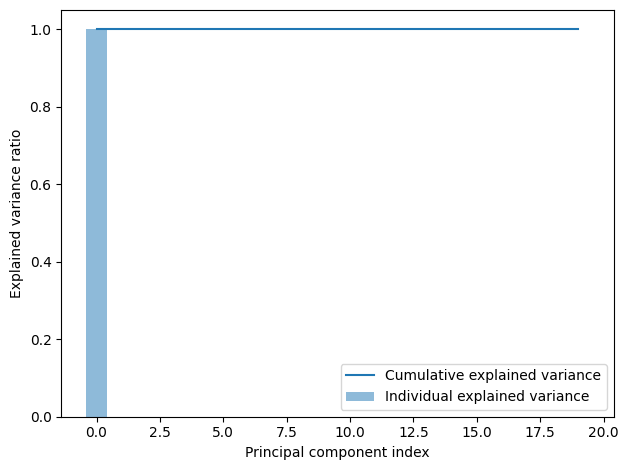

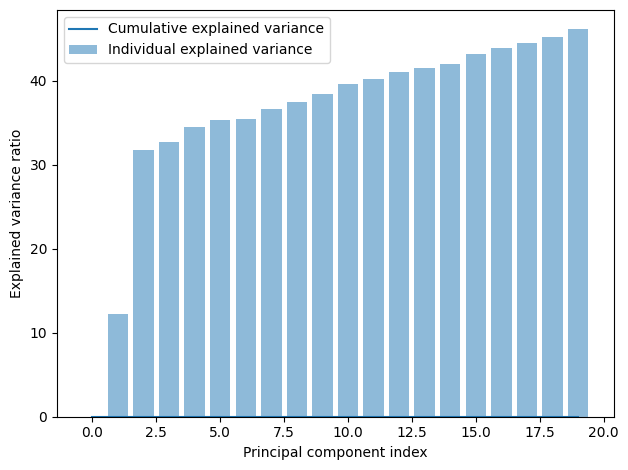

In [20]:
exp_var_pca = pca.explained_variance_ratio_[0:]

cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

exp_var_pca = pca.explained_variance_ratio_[0:]

cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), -np.log2(exp_var_pca), alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), -np.log(cum_sum_eigenvalues), where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [223]:
model = PCA(n_components=20).fit(combined)
X_pc = model.transform(combined)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = combined.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

df

,0,1
0,PC0,pcm_fftMag_spectralVariance_sma_lpgain
1,PC1,pcm_fftMag_spectralVariance_sma_de_lpgain
2,PC2,pcm_fftMag_spectralVariance_sma_stddevFallingS...
3,PC3,pcm_fftMag_spectralVariance_sma_stddevRisingSlope
4,PC4,pcm_fftMag_spectralVariance_sma_meanFallingSlope
5,PC5,pcm_fftMag_spectralVariance_sma_stddevRisingSlope
6,PC6,pcm_fftMag_spectralVariance_sma_meanRisingSlope
7,PC7,pcm_fftMag_spectralVariance_sma_de_stddevRisin...
8,PC8,pcm_fftMag_spectralVariance_sma_de_stddevFalli...
9,PC9,pcm_fftMag_spectralVariance_sma_range


## Classifier test

In [1]:
combined['label']

NameError: name 'combined' is not defined

In [25]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_pca, combined['label'], test_size=0.2, random_state=0)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

/Users/sarah/.local/share/virtualenvs/df-shibboleth-ha23P7JB/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.2657728706624606

In [37]:
X_train, X_test, y_train, y_test = train_test_split(combined.drop(['label'], axis=1), combined['label'], test_size=0.2, random_state=0)

print(X_test.shape)
print(X_train.shape)

(1268, 6373)
(5068, 6373)


In [51]:
clf.classes_
pred_probab

array([7.1191996e-04, 9.9928808e-01])

In [57]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(combined.drop(['label'], axis=1), combined['label'], test_size=0.2, random_state=0)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

print(clf.score(X_test, y_test))
pred_results = pd.DataFrame(X_test)
pred_label = clf.predict(X_test)
pred_probab = clf.predict_proba(X_test)

pred_results['actual_label'] = y_test
pred_results['predicted_label'] = pred_label
pred_results['predicted_probab_0'] = [item[0] for item in pred_probab]
pred_results['predicted_probab_1'] = [item[1] for item in pred_probab]
pred_results['max_pred_prob'] = [row['predicted_probab_0'] if row['predicted_probab_0'] >= row['predicted_probab_1'] else row['predicted_probab_1'] for id_, row in pred_results.iterrows()]
pred_results

0.9936908517350158


,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,actual_label,predicted_label,predicted_probab_0,predicted_probab_1,max_pred_prob
2074,0.711571,0.104418,0.164659,0.092779,0.197522,0.309062,0.104743,0.111540,0.216283,0.013064,...,0.567805,91.789825,43.751163,100.476460,63.406310,1.0,1.0,0.000712,9.992881e-01,0.999288
733,5.065940,0.268657,0.000000,0.593386,1.553063,2.284498,0.959677,0.731435,1.691112,0.014857,...,0.414542,139.421450,50.195625,150.372400,46.264336,0.0,0.0,1.000000,1.072190e-12,1.000000
2215,1.213179,0.574176,0.969780,0.076842,0.239876,0.435636,0.163035,0.195759,0.358794,0.013003,...,0.368285,109.117830,52.957485,112.287380,63.454723,1.0,1.0,0.001862,9.981385e-01,0.998138
1669,0.658892,0.124113,0.592199,0.080937,0.158904,0.237795,0.077967,0.078891,0.156858,0.013978,...,0.620853,130.798810,66.692154,95.905000,65.171790,1.0,1.0,0.001597,9.984034e-01,0.998403
1453,0.632626,0.537594,0.755639,0.058299,0.195758,0.371507,0.137459,0.175749,0.313208,0.013383,...,0.437724,127.773380,63.666610,107.991930,59.230988,1.0,1.0,0.017146,9.828544e-01,0.982854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4492,0.906061,0.295515,0.007916,0.113192,0.228568,0.389610,0.115376,0.161042,0.276419,0.013701,...,0.491414,101.138790,54.290040,112.363110,56.776012,1.0,1.0,0.004149,9.958514e-01,0.995851
536,0.969072,0.134228,0.966443,0.034841,0.182275,0.391073,0.147435,0.208797,0.356232,0.012864,...,0.684684,131.205600,55.223972,109.205536,51.798200,1.0,1.0,0.001576,9.984243e-01,0.998424
59,5.848828,0.031111,0.928889,1.276664,2.055326,3.602380,0.778662,1.547054,2.325716,0.017874,...,0.555008,141.423420,58.549335,135.954700,75.800220,0.0,0.0,0.920279,7.972068e-02,0.920279
2858,1.185534,0.269912,0.115044,0.092874,0.238656,0.400197,0.145782,0.161541,0.307323,0.014097,...,0.449984,115.839905,75.123520,129.546950,63.883420,1.0,1.0,0.000749,9.992505e-01,0.999251


In [56]:
pred

NameError: name 'pred' is not defined

# NEXT: Pipeline for individual classifiers

# NEXT: Combine my cadence features onto the bottom of opensmile ones

### <font color=red> Is this because the fakes are all just at a differewnt sample rate? Retry with ingestion of all at 16000
### Also revisit the principal components because component zero seems to dominate! 

In [182]:
import beepy
beepy.beep(sound=1)

In [9]:
#real_word_files = [str(item) for item in list(pathlib.Path('/Volumes/2022_OTHER/TIMIT-fake/word_files/real_bigram').rglob("*.WAV"))]
fake_word_files = [str(item) for item in list(pathlib.Path('/Volumes/2022_OTHER/TIMIT-fake/word_files/fake_bigram').rglob("*.WAV"))]

In [11]:
file

'/Volumes/2022_OTHER/TIMIT-fake/word_files/fake_bigram/a_30000_FGCS0_SX406.WAV'

In [34]:
def resample_files(word_files, target_sr, label):
    counter = 0
    for file in word_files:
        audio, sr = librosa.load(file)
        audio_resample = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        out_file_path =  '/'.join(file.split('/')[:-2])
        out_file_name = file.split('/')[-1]
        out_file = out_file_path + '/' + f'{label}_bigram_16khz/' + out_file_name
        sf.write(f'{out_file}', audio_resample, target_sr)
        
        if counter % 100 == 0:
            print(f'{counter*100/len(word_files)}% complete')
        counter = counter + 1
    
    return None
        
resample_files(fake_word_files, 16000, 'fake')
# No need to run for real as real is already 16khz currently
# resample_files(real_word_files, 16000, 'real')

0.0% complete
0.8715356458079135% complete
1.743071291615827% complete
2.6146069374237406% complete
3.486142583231654% complete
4.357678229039568% complete
5.229213874847481% complete
6.100749520655395% complete
6.972285166463308% complete
7.843820812271222% complete
8.715356458079135% complete
9.586892103887049% complete
10.458427749694962% complete
11.329963395502876% complete
12.20149904131079% complete
13.073034687118703% complete
13.944570332926617% complete
14.81610597873453% complete
15.687641624542444% complete
16.559177270350357% complete
17.43071291615827% complete
18.302248561966184% complete
19.173784207774098% complete
20.04531985358201% complete
20.916855499389925% complete
21.78839114519784% complete
22.659926791005752% complete
23.531462436813666% complete
24.40299808262158% complete
25.274533728429493% complete
26.146069374237406% complete
27.01760502004532% complete
27.889140665853233% complete
28.760676311661147% complete
29.63221195746906% complete
30.50374760327697

In [35]:
import beepy
beepy.beep()